## Ancient Graffiti

* Project [proposal](https://docs.google.com/document/d/15MjayQjkNGTeL-1R-D_9iZZYdAhwY0RESCbXlQmoco0/edit?usp=sharing)
* Data source: [Ancient Graffiti Project](http://ancientgraffiti.org/Graffiti/results)
* [Epigraphic conventions](http://ancientgraffiti.org/about/main/epigraphic-conventions/) from Ancient Graffiti Project

* the fields in the dataset is similar to the left filter bar on website

This notebook:
* Part 0: Load Data
* Part 0.5: EDA
* Part 1: Data Preprocessing
* Part 2: NLP (NER/sentiment analysis/topicmodeling)
* Part 3: Social network analysis
* visualization

Q: where can i find the date of the graffiti?

Idea:
- wall text has a ton of missing parts, is it possible to predict the missing parts and complete the sentences?
    - [LatinBert](https://github.com/dbamman/latin-bert) text infilling 


#### Part 0: Load Data, preprocessing

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_json('filtered-results.json')
print(df.shape)
df.head()

(2124, 27)


,content,bibliography,apparatus,photos,sourceFindSpot,principleContributors,lastRevision,editor,contentTranslation,caption,writingStyleInEnglish,languageInEnglish,property,cil,figuralInfo,contributors,agpId,citation,langner,segment,preciseLocation,commentary,graffitoHeight,graffitoLength,minLetterHeight,maxLetterHeight,column
0,S IIIIIIIIIIII XX,"CIL 04, 10651b (1)<br>http://ancientgraffiti.o...",Textus secundum (1); periit (2)<br>Contulerunt...,[],"Ercolano (Napoli), Insula Orientalis II.2-3, P...",Holly Sypniewski,2017-08-09,Rebecca Benefiel,S 32,Tally marks,Graffito/incised,Latin,"{'italianPropertyName': 'Pistrinum', 'insula':...",10651b,{},,AGP-EDR154423,"AGP-EDR154423, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Vasileus habitat\nPutelis (:Puteolis) in castr...,"Rend. Ac. Arch. Nap., 33, 1958, p. 242, nr. 4 ...",Textus secundum (2)<br>v. 1: VASILEVS pro BASI...,[],"Ercolano (Napoli), Insula III.14, Casa a Grati...",Holly Sypniewski,2022-07-19,Rebecca Benefiel,Vasileus lives at Puteoli in the camp of the e...,Graffito mentioning the city of Puteoli,Graffito/incised,Latin,"{'englishPropertyName': 'House of Wattlework',...",10502,{},,AGP-EDR151822,"AGP-EDR151822, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,((:herma viri cum palma)),"Rend. Ac. Arch. Nap., 33, 1958, p. 266 (M. Del...",Textus secundum (3); periit (3)<br>Contulerunt...,[],"Ercolano (Napoli), Insula VI.1,7-10, Terme Cen...",Holly Sypniewski,2017-08-11,Rebecca Benefiel,NaN,Drawing of a man,charcoal,NaN,"{'englishPropertyName': 'Central Baths', 'ital...",10604,"{'drawingTags': [{'name': 'Human figures', 'de...",,AGP-EDR147607,"AGP-EDR147607, <i>The Ancient Graffiti Project...",384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mortus (:Mortuus)\nErcolanius (:Hercolanius),"Riv. Stud. Pomp., 11, 2000, p. 277-279, fig. 1...",Textus et mensurae secundum (1)<br>v. 1: lat.:...,"[{'photoId': '156998', 'thumbPath': 'http://ww...","Ercolano (Napoli), Terme Suburbane",Holly Sypniewski,2017-08-09,Rebecca Benefiel,Hercolanius is dead.,Graffito,Graffito/incised,Latin,"{'englishPropertyName': 'Suburban Baths', 'ita...",Varone 2000,{},,AGP-EDR156998,"AGP-EDR156998, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,((:cervus a viro laqueo captus et a cane assul...,"CIL 04, 10561 (nota) (1)<br>Tran Tam Tinh, La ...","Textus secundum (4), mensura secundum (3)<br>i...","[{'photoId': '145008', 'thumbPath': 'http://ww...","Ercolano (Napoli), Insula IV.21, Casa dei Cervi",Holly Sypniewski,2017-08-07,Rebecca Benefiel,NaN,Drawing of a stag,Graffito/incised,NaN,"{'englishPropertyName': 'House of Stags', 'ita...",10561,"{'drawingTags': [{'name': 'Human figures', 'de...",,AGP-EDR145008,"AGP-EDR145008, <i>The Ancient Graffiti Project...",1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Upon inspecting the dataframe, we find many columns contain nested json data:
- property
- figuralInfo
- segment

...others

These three seem to be the most important features related to the property and location of the graffiti thats need to be flattened.


In [3]:
# uses a recursive function to check if any column in a DataFrame contains JSON data, even if it is nested multiple levels deep
def is_json(data):
    try:
        json.loads(data)
        return True
    except (ValueError, TypeError):
        return False

def check_for_json(df):
    # Check if any columns in the DataFrame contain JSON data
    for col in df.columns:
        if df[col].dtype == 'object':
            if df[col].apply(lambda x: is_json(x)).any():
                print(f"Column '{col}' contains JSON data")
            try:
                check_for_json(pd.json_normalize(df[col]))
            except:
                pass

# Check for JSON data in the DataFrame
check_for_json(df)

Column 'photoId' contains JSON data
Column 'contentTranslation' contains JSON data
Column 'propertyNumber' contains JSON data
Column 'insula.city.pleiadesId' contains JSON data
Column 'additionalEntrances' contains JSON data
Column 'cil' contains JSON data
Column 'contributors' contains JSON data
Column 'langner' contains JSON data
Column 'street.city.pleiadesId' contains JSON data


In [4]:
# flatten the nested JSON data in property, figuralInfo, and segment columns, and store them in new columns
from pandas.io.json import json_normalize

# Flatten the 'property' column
property_df = pd.json_normalize(df['property'])
# Add the flattened columns to the original DataFrame
df = pd.concat([df, property_df], axis=1)
# Remove the original 'property' column
df = df.drop('property', axis=1)

# figuralInfo
figuralInfo_df = pd.json_normalize(df['figuralInfo'])
df = pd.concat([df, figuralInfo_df], axis=1)
df = df.drop('figuralInfo', axis=1)

# segment
segment_df = pd.json_normalize(df['segment'])
df = pd.concat([df, segment_df], axis=1)
df = df.drop('segment', axis=1)

In [5]:
# columns after flattening
print(len(df.columns), " columns\n", df.columns)

45  columns
 Index(['content', 'bibliography', 'apparatus', 'photos', 'sourceFindSpot',
       'principleContributors', 'lastRevision', 'editor', 'contentTranslation',
       'caption', 'writingStyleInEnglish', 'languageInEnglish', 'cil',
       'contributors', 'agpId', 'citation', 'langner', 'preciseLocation',
       'commentary', 'graffitoHeight', 'graffitoLength', 'minLetterHeight',
       'maxLetterHeight', 'column', 'italianPropertyName', 'propertyTypes',
       'numberOfGraffiti', 'uri', 'propertyNumber', 'insula.shortName',
       'insula.fullName', 'insula.city.name', 'insula.city.pleiadesId',
       'englishPropertyName', 'additionalEntrances', 'propertyName',
       'drawingTags', 'descriptionInEnglish', 'descriptionInLatin', 'uri',
       'segmentName', 'street.city.name', 'street.city.pleiadesId',
       'street.streetName', 'street.pompeiiinPicturesURL'],
      dtype='object')


In [6]:
df.head()

,content,bibliography,apparatus,photos,sourceFindSpot,principleContributors,lastRevision,editor,contentTranslation,caption,writingStyleInEnglish,languageInEnglish,cil,contributors,agpId,citation,langner,preciseLocation,commentary,graffitoHeight,graffitoLength,minLetterHeight,maxLetterHeight,column,italianPropertyName,propertyTypes,numberOfGraffiti,uri,propertyNumber,insula.shortName,insula.fullName,insula.city.name,insula.city.pleiadesId,englishPropertyName,additionalEntrances,propertyName,drawingTags,descriptionInEnglish,descriptionInLatin,uri,segmentName,street.city.name,street.city.pleiadesId,street.streetName,street.pompeiiinPicturesURL
0,S IIIIIIIIIIII XX,"CIL 04, 10651b (1)<br>http://ancientgraffiti.o...",Textus secundum (1); periit (2)<br>Contulerunt...,[],"Ercolano (Napoli), Insula Orientalis II.2-3, P...",Holly Sypniewski,2017-08-09,Rebecca Benefiel,S 32,Tally marks,Graffito/incised,Latin,10651b,,AGP-EDR154423,"AGP-EDR154423, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pistrinum,"[{'name': 'Bakery', 'description': ''}]",16,Herculaneum/InsulaOrientalisII/2-3,2-3,InsulaOrientalisII,Insula Orientalis II,Herculaneum,432873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Vasileus habitat\nPutelis (:Puteolis) in castr...,"Rend. Ac. Arch. Nap., 33, 1958, p. 242, nr. 4 ...",Textus secundum (2)<br>v. 1: VASILEVS pro BASI...,[],"Ercolano (Napoli), Insula III.14, Casa a Grati...",Holly Sypniewski,2022-07-19,Rebecca Benefiel,Vasileus lives at Puteoli in the camp of the e...,Graffito mentioning the city of Puteoli,Graffito/incised,Latin,10502,,AGP-EDR151822,"AGP-EDR151822, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa a Graticcio,"[{'name': 'House', 'description': 'Residential...",5,Herculaneum/III/14,14,III,Insula III,Herculaneum,432873,House of Wattlework,"13,15",House of Wattlework,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,((:herma viri cum palma)),"Rend. Ac. Arch. Nap., 33, 1958, p. 266 (M. Del...",Textus secundum (3); periit (3)<br>Contulerunt...,[],"Ercolano (Napoli), Insula VI.1,7-10, Terme Cen...",Holly Sypniewski,2017-08-11,Rebecca Benefiel,NaN,Drawing of a man,charcoal,NaN,10604,,AGP-EDR147607,"AGP-EDR147607, <i>The Ancient Graffiti Project...",384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Terme Centrali,"[{'name': 'Baths', 'description': ''}]",21,"Herculaneum/VI/1,7-10","1,7-10",VI,Insula VI,Herculaneum,432873,Central Baths,NaN,Central Baths,"[{'name': 'Human figures', 'description': 'dra...",bust of man with palm,herma viri cum palma,NaN,NaN,NaN,NaN,NaN,NaN
3,Mortus (:Mortuus)\nErcolanius (:Hercolanius),"Riv. Stud. Pomp., 11, 2000, p. 277-279, fig. 1...",Textus et mensurae secundum (1)<br>v. 1: lat.:...,"[{'photoId': '156998', 'thumbPath': 'http://ww...","Ercolano (Napoli), Terme Suburbane",Holly Sypniewski,2017-08-09,Rebecca Benefiel,Hercolanius is dead.,Graffito,Graffito/incised,Latin,Varone 2000,,AGP-EDR156998,"AGP-EDR156998, <i>The Ancient Graffiti Project...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Terme Suburbane,"[{'name': 'Baths', 'description': ''}]",13,Herculaneum/OutsideWalls/ow2,ow2,OutsideWalls,Outside Walls,Herculaneum,432873,Suburban Baths,NaN,Suburban Baths,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,((:cervus a viro laqueo captus et a cane assul...,"CIL 04, 10561 (nota) (1)<br>Tran Tam Tinh, La ...","Textus secundum (4), mensura secundum (3)<br>i...","[{'photoId': '145008', 'thumbPath': 'http://ww...","Ercolano (Napoli), Insula IV.21, Casa dei Cervi",Holly Sypniewski,2017-08-07,Rebecca Benefiel,NaN,Drawing of a stag,Graffito/incised,NaN,10561,,AGP-EDR145008,"AGP-EDR145008, <i>The Ancient Graffiti Project...",1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa dei Cervi,"[{'name': 'House', 'description': 'Residential...",24,Herculaneum/IV/21,21,IV,Insula IV,Herculaneum,432873,House of Stags,NaN,House of the Stags,"[{'name': 'Human figures', 'description': 'dra...",stag captured by a man with a rope and attacke...,cervus a viro laqueo captus et a cane assultatus,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   content                      2117 non-null   object 
 1   bibliography                 2124 non-null   object 
 2   apparatus                    2124 non-null   object 
 3   photos                       2124 non-null   object 
 4   sourceFindSpot               2124 non-null   object 
 5   principleContributors        2115 non-null   object 
 6   lastRevision                 2115 non-null   object 
 7   editor                       2115 non-null   object 
 8   contentTranslation           1030 non-null   object 
 9   caption                      1580 non-null   object 
 10  writingStyleInEnglish        2124 non-null   object 
 11  languageInEnglish            1692 non-null   object 
 12  cil                          1758 non-null   object 
 13  contributors      

In [8]:
# percent of missing values in each column
percent_missing = df.isnull().sum() * 100 / len(df)

# create a list of column names with over 80% missing values
columns_to_drop = percent_missing[percent_missing > 80].index.tolist()

# drop those columns
df.drop(columns_to_drop, axis = 1, inplace = True)

In [9]:
print(f"Percent of missing values in each column: {percent_missing}")
print(f"Columns being dropped: {columns_to_drop}")

Percent of missing values in each column: content                         0.329567
bibliography                    0.000000
apparatus                       0.000000
photos                          0.000000
sourceFindSpot                  0.000000
principleContributors           0.423729
lastRevision                    0.423729
editor                          0.423729
contentTranslation             51.506591
caption                        25.612053
writingStyleInEnglish           0.000000
languageInEnglish              20.338983
cil                            17.231638
contributors                   45.103578
agpId                           0.000000
citation                        0.000000
langner                        88.323917
preciseLocation                65.677966
commentary                     92.278719
graffitoHeight                 86.158192
graffitoLength                 86.205273
minLetterHeight                92.372881
maxLetterHeight                92.372881
column         

In [10]:
# look at the columns
print(" dataset has ", len(df.columns), " columns\n", df.columns)

 dataset has  32  columns
 Index(['content', 'bibliography', 'apparatus', 'photos', 'sourceFindSpot',
       'principleContributors', 'lastRevision', 'editor', 'contentTranslation',
       'caption', 'writingStyleInEnglish', 'languageInEnglish', 'cil',
       'contributors', 'agpId', 'citation', 'preciseLocation', 'column',
       'italianPropertyName', 'propertyTypes', 'numberOfGraffiti',
       'propertyNumber', 'insula.shortName', 'insula.fullName',
       'insula.city.name', 'insula.city.pleiadesId', 'englishPropertyName',
       'additionalEntrances', 'propertyName', 'drawingTags',
       'descriptionInEnglish', 'descriptionInLatin'],
      dtype='object')


In [11]:
# drop photos, propertyTypes, drawingTags, column, contributor related columns
df.drop(['photos', 'drawingTags', 'column', 'propertyTypes', 'bibliography', 'principleContributors', 'lastRevision', 'editor', 'contributors', 'agpId'], axis=1, inplace = True)
print("After dropping a few columns related to contributors: ", len(df.columns), " columns\n", df.columns)

After dropping a few columns related to contributors:  22  columns
 Index(['content', 'apparatus', 'sourceFindSpot', 'contentTranslation',
       'caption', 'writingStyleInEnglish', 'languageInEnglish', 'cil',
       'citation', 'preciseLocation', 'italianPropertyName',
       'numberOfGraffiti', 'propertyNumber', 'insula.shortName',
       'insula.fullName', 'insula.city.name', 'insula.city.pleiadesId',
       'englishPropertyName', 'additionalEntrances', 'propertyName',
       'descriptionInEnglish', 'descriptionInLatin'],
      dtype='object')


In [12]:
df.shape

(2124, 22)

In [13]:
# import cufflinks library
import cufflinks as cf
# import modules to work with data viz offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# connect the javascript to notebook with init
init_notebook_mode(connected=True)
# use cufflinks offline
cf.go_offline()

In [14]:
df['languageInEnglish'].value_counts().iplot(
    kind='bar',
    xTitle='language',
    linecolor='black',
    colors='blue',
    yTitle='count',
    opacity = 0.8,
    title='Language Distribution')

In [16]:
# show language distribution in percentages
df['languageInEnglish'].value_counts()/len(df['languageInEnglish'])

Latin          0.669962
Greek          0.104049
Latin/Greek    0.017420
other          0.005179
Name: languageInEnglish, dtype: float64

In [17]:
df['insula.city.name'].value_counts().iplot(
    kind='bar',
    xTitle='city',
    colors='blue',
    linecolor='black',
    yTitle='count',
    opacity = 0.8,
    title='City Distribution')

In [18]:
df['insula.fullName'].value_counts().iplot(
    kind='bar',
    xTitle='city',
    colors='blue',
    linecolor='black',
    yTitle='count',
    opacity = 0.8,
    title='Insula Distribution')

In [19]:
# save the DataFrame as a csv file
df.to_csv('app/data/df.csv', index=False)

In [20]:
content_df = df[["content", "contentTranslation", "languageInEnglish"]]
content_df

,content,contentTranslation,languageInEnglish
0,S IIIIIIIIIIII XX,S 32,Latin
1,Vasileus habitat\nPutelis (:Puteolis) in castr...,Vasileus lives at Puteoli in the camp of the e...,Latin
2,((:herma viri cum palma)),NaN,NaN
3,Mortus (:Mortuus)\nErcolanius (:Hercolanius),Hercolanius is dead.,Latin
4,((:cervus a viro laqueo captus et a cane assul...,NaN,NaN
...,...,...,...
2119,&#12296;:altitudinum variarum&#12297;\n\nIRI ...,(Individual letters),Latin
2120,Feliclâm (:Feliculam) ego hic futui{ì},NaN,Latin
2121,Ad miror (:admiror) paries\nte non cecidise (:...,NaN,Latin
2122,Conticuere omnes,NaN,Latin


### Text preprocessing 
  - understand the epigraphic conventions from Ancient Graffiti Project: http://ancientgraffiti.org/about/main/epigraphic-conventions/
    

In [21]:
import re
import html  # convert html entities to regular letters

In [22]:
# drop rows with missing values in content column
content_df.dropna(subset = ["content"], inplace=True)

# should be 0 otherwvise will lead to errors later
content_df['content'].isnull().sum()

0

In [23]:
# ABC: Letters whose reading is clear but meaning is incomprehensible
# if contains "ABC", or nan values, drop the row
content_df = content_df[~(content_df.content.str.contains("ABC"))]
content_df.head()
content_df.shape # lost 23 rows

(2094, 3)

Decode HTML entities

The text data contain a mix of regular characters and HTML entities representing Greek characters. HTML entities have a specific format, starting with an ampersand (&) and ending with a semicolon (;). The characters between them indicate the character being represented. For example, &amp; represents the ampersand character (&), &#945; represents the Greek letter alpha (α), and so on. To better understand the text, we decode the HTML entities into their corresponding characters. 

e.g. "dos pygiza &#948;&#8056;&#962; &#960;&#965;&#947;&#943;&#963;&#945;&#953;"

In [24]:
# test html unescape
text = "dos pygiza &#948;&#8056;&#962; &#960;&#965;&#947;&#943;&#963;&#945;&#953;"
decoded_text = html.unescape(text)
print(decoded_text)

dos pygiza δὸς πυγίσαι


In [25]:
# if (:abc) pattern is found, replace the previous word with the word inside the parentheses
# pattern is ( followed by : and followed by some alphebets and ends in )
def replace_previous_word(text):
    pattern = r'(\w+)\s\((:[a-zA-Z]+)\)'

    # Define a function to be called as the replacement function by re.sub()
    def repl(match):
        return match.group(2)[1:]  # Return the word inside the parentheses without the colon

    # Use re.sub() to replace the previous word with the word inside the parentheses
    modified_text = re.sub(pattern, repl, text)

    return modified_text

# Example usage
text = "Hello (:world) I am (:example),, ((:another test ))"
modified_text = replace_previous_word(text)
print(modified_text)

world I example,, ((:another test ))


In [26]:
# create a new column to store preprocessed text

# decode html entities to their corresponding characters
content_df['preprocessed'] = content_df['content'].apply(lambda x: html.unescape(x))

# get rid of ?
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: x.replace("?", ""))

# find (:abc) pattern, apply twice to remove the second (:abc) pattern
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: replace_previous_word(x))
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: replace_previous_word(x))

# ((:abc)) --> abc
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: re.sub(r"\(\((:[\S\s]+)\)\)", r"\1", x).replace(":", ""))

# a(bc) --> abc
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: x.replace("(", "").replace(")", ""))

# [abc], [[abc]] --> abc, [ab c] --> ab c, but not [---]
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: re.sub(r"\[([\w\s]+)\]", r"\1", x))

# lowercase
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: x.lower())

# replace "+" with ""
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: x.replace("+", ""))

# replace "\n" with ", " 
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: x.replace("\n", ", "))

# remove everything between 〈 〉and <>
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: re.sub(r"〈.*?〉", "", x))
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: re.sub(r"<.*?>", "", x))

# remove 〚〛 and everything in between
content_df['preprocessed'] = content_df['preprocessed'].apply(lambda x: re.sub(r"〚.*?〛", "", x))


In [27]:
# test [abc], [[abc]] --> abc, not [---]
text = "The [quick] brown [fox] jumps over the [lazy] dog [---]."
new_text = re.sub(r"\[([a-zA-Z]+)\]", r"\1", text)
print(new_text)  # Output: 'The quick brown fox jumps over the lazy dog.'

The quick brown fox jumps over the lazy dog [---].


In [28]:
# test a(bc)	Abbreviation; text was never written out; expanded by editor
text = "a((bcd))"
text = text.replace("(", "").replace(")", "")
print(text)

abcd


In [29]:
#  test [abc]	Letters once present, now missing due to damage to the surface or support
# [[abc]]	Letters intentionally erased in antiquity
# [abc], [[abc]]	--> abc
text = "[abc], [[qwq]]"
text = text.replace("[", "").replace("]", "")
print(text)

abc, qwq


Text Infilling

Now our text is cleaned and ready for us to try LatinBert Latin text in filling and see if we can make more sense out of the sentences.

- Separte latin and greek text because each language needs its own model that is pretrained on large corpus
- For Latin: run the latinbert model on texts with [---] as [MASK]
- For Greek: run the Greek Bert model (from hugging face) on texts with [---] as [MASK]

In [30]:
# make new df for latin and greek texts
latin_content = content_df.loc[(content_df['languageInEnglish'] == 'Latin') | (content_df['languageInEnglish'] == 'Latin/Greek')]
latin_content.reset_index(drop=True, inplace=True)  

greek_content = content_df.loc[(content_df['languageInEnglish'] == 'Greek') | (content_df['languageInEnglish'] == 'Latin/Greek')]
greek_content.reset_index(drop=True, inplace=True)

In [31]:
# example latinbert masking workflow from github
from transformers import pipeline

path_to_latin_bert = "./latin-bert-huggingface-main/bert-base-latin-uncased/"
unmasker = pipeline('fill-mask', model=path_to_latin_bert)
#print(unmasker("""dvces et reges carthaginiensivm hanno et mago qui [MASK] punico bello cornelium consulem aput liparas ceperunt"""))
print(unmasker("""dvces et reges carthaginiensivm hanno et mago qui [MASK] punico bello cornelium consulem aput liparas ceperunt""")[0]["sequence"])

Some weights of the model checkpoint at ./latin-bert-huggingface-main/bert-base-latin-uncased/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


dvces et reges carthaginiensivm hanno et mago qui primo punico bello cornelium consulem aput liparas ceperunt


In [32]:
def mask_and_unmask(df):
    for i, row in df.iterrows():
        if "[---]" in row["preprocessed"] or "[- - -]" in row["preprocessed"] or "[----]" in row["preprocessed"]:
            row["preprocessed"] = row["preprocessed"].replace("[---]", "[MASK]").replace("[- - -]", "[MASK]")

        while "[MASK]" in row["preprocessed"]:
            # Replace only the first [MASK] token and restore the other ones to reduce noise for model predictions
            single_mask_text = row["preprocessed"].replace("[MASK]", "[X]", 1).replace("[MASK]", "[XX]").replace("[X]", "[MASK]")
            unmasked = unmasker(single_mask_text)

            if not unmasked:
                break

            unmasked_text = unmasked[0]["token_str"]
            row["preprocessed"] = row["preprocessed"].replace("[MASK]", unmasked_text, 1).replace("[XX]", "[MASK]")

In [33]:
mask_and_unmask(latin_content)

Final preprocessing for Latin content
- remove remaining special characters

In [34]:
latin_content['preprocessed'] = latin_content['preprocessed'].apply(lambda x: x.replace('-', '').replace('+', '').replace('?', '').replace('[', '').replace(']', '').replace("  ", " "))

In [35]:
latin_content.head()

,content,contentTranslation,languageInEnglish,preprocessed
0,S IIIIIIIIIIII XX,S 32,Latin,s iiiiiiiiiiii xx
1,Vasileus habitat\nPutelis (:Puteolis) in castr...,Vasileus lives at Puteoli in the camp of the e...,Latin,"vasileus habitat, puteolis in castris augusti ..."
2,Mortus (:Mortuus)\nErcolanius (:Hercolanius),Hercolanius is dead.,Latin,"mortuus, hercolanius"
3,&#919;dibus (:Idibus) Ianyaris (:Ianuarias)\nm...,"On the Ides of January, the guide (religious g...",Latin/Greek,"idibus ianuarias, mystacogus mystagogus, μυστα..."
4,III non(as) M&#770;a&#770;i(as)\nVII idus paer...,Three days before the Nones of May. Seven days...,Latin,"iii nonas m̂âias, vii idus periit"


In [36]:
# save to csv
latin_content.to_csv('app/data/latin_content.csv', encoding='utf-8', index=False)

#### Now we apply the same methods for greek_content
- masking and infilling using hugging face greek bert model https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1?text=%CE%A3%CE%AE%CE%BC%CE%B5%CF%81%CE%B1+%CE%B5%CE%AF%CE%BD%CE%B1%CE%B9+%CE%BC%CE%B9%CE%B1+%5BMASK%5D+%CE%BC%CE%AD%CF%81%CE%B1. 

In [37]:
greek_content.head()

,content,contentTranslation,languageInEnglish,preprocessed
0,&#919;dibus (:Idibus) Ianyaris (:Ianuarias)\nm...,"On the Ides of January, the guide (religious g...",Latin/Greek,"idibus ianuarias, mystacogus mystagogus, μυστα..."
1,&#916;&#953;&#959;&#947;&#8051;&#957;&#951;&#9...,"Diogenes the Cynic philospher, seeing a woman ...",Greek,"διογένης ὁ κυνικὸς φιλόσοφος, ἰδὼν γυναῖκα ὑπὸ..."
2,Cab=\ninio (:&#931;&#945;&#946;&#943;&#957;&#9...,Sabinio (Σαβινιο),Greek,"cab=, inio σαβίνιο, s s retrogradum"
3,&#913;&#914;&#915;&#916;&#917;&#918;&#919;&#92...,Beginning of Greek alphabet,Greek,αβγδεζηθικλμ
4,&#7961;&#961;&#956;&#943;&#945;(&#962;),Hermias (i.e. a name),Greek,ἑρμίας


In [38]:
import unicodedata

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

accented_string = "Αυτή είναι η Ελληνική έκδοση του BERT."
unaccented_string = strip_accents_and_lowercase(accented_string)

print(unaccented_string) # αυτη ειναι η ελληνικη εκδοση του bert.

αυτη ειναι η ελληνικη εκδοση του bert.


In [39]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
import torch
from transformers import *

/Users/ming/miniconda3/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.



In [41]:
# Load model and tokenizer
tokenizer_greek = AutoTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
lm_model_greek = AutoModelWithLMHead.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')

loading configuration file config.json from cache at /Users/ming/.cache/huggingface/hub/models--nlpaueb--bert-base-greek-uncased-v1/snapshots/ec2b8f88dd215b5246f2f850413d5bff90d7540d/config.json
Model config BertConfig {
  "_name_or_path": "nlpaueb/bert-base-greek-uncased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 35000
}

loading file vocab.txt from cache at /Users/ming/.cache/huggingface/hub/models--nlpaueb--bert-base-greek-uncased-v1/snapshots/ec2b8f88dd

In [42]:
# ================ EXAMPLE 1 ================
text_1 = 'O ποιητής έγραψε ένα [MASK] .'
# EN: 'The poet wrote a [MASK].'
input_ids = tokenizer_greek.encode(text_1)
print(tokenizer_greek.convert_ids_to_tokens(input_ids))
# ['[CLS]', 'o', 'ποιητης', 'εγραψε', 'ενα', '[MASK]', '.', '[SEP]']
outputs = lm_model_greek(torch.tensor([input_ids]))[0]
print(tokenizer_greek.convert_ids_to_tokens(outputs[0, 5].max(0)[1].item()))
# the most plausible prediction for [MASK] is "song"

# ================ EXAMPLE 2 ================
text_2 = 'Είναι ένας [MASK] άνθρωπος.'
# EN: 'He is a [MASK] person.'
input_ids = tokenizer_greek.encode(text_2)
print(tokenizer_greek.convert_ids_to_tokens(input_ids))
# ['[CLS]', 'ειναι', 'ενας', '[MASK]', 'ανθρωπος', '.', '[SEP]']
outputs = lm_model_greek(torch.tensor([input_ids]))[0]
print(tokenizer_greek.convert_ids_to_tokens(outputs[0, 3].max(0)[1].item()))
# the most plausible prediction for [MASK] is "good"

['[CLS]', 'o', 'ποιητης', 'εγραψε', 'ενα', '[MASK]', '.', '[SEP]']
τραγουδι
['[CLS]', 'ειναι', 'ενας', '[MASK]', 'ανθρωπος', '.', '[SEP]']
καλος


In [43]:
def unmask_greek_sentences(df, text_column):
    for idx, row in df.iterrows():
        text = row[text_column]
        
        while "[MASK]" in text:
            input_ids = tokenizer_greek.encode(text)
            mask_idx = input_ids.index(tokenizer_greek.mask_token_id)
            outputs = lm_model_greek(torch.tensor([input_ids]))[0]
            predicted_token_id = outputs[0, mask_idx].max(0)[1].item()
            predicted_token = tokenizer_greek.convert_ids_to_tokens(predicted_token_id)
            text = text.replace("[MASK]", predicted_token, 1)
        
        df.at[idx, text_column] = text
    return df

# Example usage
greek_sentences = [
    'O ποιητής έγραψε ένα [MASK] [MASK] .',
    'Είναι ένας [MASK] άνθρωπος.'
]

data = {
    'Greek Sentences': greek_sentences
}

df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)

print("\nUpdated DataFrame:")
df_unmasked = unmask_greek_sentences(df, 'Greek Sentences')
print(df_unmasked)


Original DataFrame:
                        Greek Sentences
0  O ποιητής έγραψε ένα [MASK] [MASK] .
1           Είναι ένας [MASK] άνθρωπος.

Updated DataFrame:
                 Greek Sentences
0  O ποιητής έγραψε ένα μονο . .
1     Είναι ένας καλος άνθρωπος.


In [44]:
def mask_and_unmask(df, text_column):
    for idx, row in df.iterrows():
        text = row[text_column]
        if "[---]" in text or "[- - -]" in text or "[----]" in text:
            text = text.replace("[---]", "[MASK]").replace("[- - -]", "[MASK]").replace("[----]", "[MASK]")

        while "[MASK]" in text:
            input_ids = tokenizer_greek.encode(text)
            mask_idx = input_ids.index(tokenizer_greek.mask_token_id)
            outputs = lm_model_greek(torch.tensor([input_ids]))[0]
            predicted_token_id = outputs[0, mask_idx].max(0)[1].item()
            predicted_token = tokenizer_greek.convert_ids_to_tokens(predicted_token_id)
            text = text.replace("[MASK]", predicted_token, 1)
        
        df.at[idx, text_column] = text
    return df

mask_and_unmask(greek_content, 'preprocessed')

,content,contentTranslation,languageInEnglish,preprocessed
0,&#919;dibus (:Idibus) Ianyaris (:Ianuarias)\nm...,"On the Ides of January, the guide (religious g...",Latin/Greek,"idibus ianuarias, mystacogus mystagogus, μυστα..."
1,&#916;&#953;&#959;&#947;&#8051;&#957;&#951;&#9...,"Diogenes the Cynic philospher, seeing a woman ...",Greek,"διογένης ὁ κυνικὸς φιλόσοφος, ἰδὼν γυναῖκα ὑπὸ..."
2,Cab=\ninio (:&#931;&#945;&#946;&#943;&#957;&#9...,Sabinio (Σαβινιο),Greek,"cab=, inio σαβίνιο, s s retrogradum"
3,&#913;&#914;&#915;&#916;&#917;&#918;&#919;&#92...,Beginning of Greek alphabet,Greek,αβγδεζηθικλμ
4,&#7961;&#961;&#956;&#943;&#945;(&#962;),Hermias (i.e. a name),Greek,ἑρμίας
...,...,...,...,...
247,&#924;&#917;&#918;&#919;&#920;&#921;&#922;&#92...,NaN,Greek,"μεζηθικλλι, ξοπ̣με"
248,&#913;&#914;&#929;&#916;&#913;&#929;&#913;[+5?...,(incomprehensible series of Greek letters),Greek,"αβρδαρα[5]ωαρ[1]αρμ, μiiροαβ · οο[2]μ[1]ρι[2]..."
249,&#7945;r&#960;&#959;&#954;r&#8118;(&#962;) (:&...,NaN,Latin/Greek,ἁrποκrᾶς ἁρποκρᾶς
250,&#7944;&#956;&#941;&#961;&#953;&#956;&#957;&#9...,NaN,Greek,"ἀμέριμνος ἐμνήσθη ἁρμονίας τῆς εἰδίας κυρίας ,..."


In [45]:
# ensure that commas and periods appear in the correct places within a sentence, as it influence google translate results a lot
def clean_sentence(sentence):
    # Remove commas and periods at the beginning of the sentence
    sentence = re.sub(r'[,.]+(?=\w)', '', sentence)
     
    # Replace multiple consecutive commas with a single comma
    sentence = re.sub(r',[,]+', ',', sentence)

    # Remove any whitespace before a comma or a period
    sentence = re.sub(r'\s+([,.])', r'\1', sentence)

    return sentence

# Example usage:
original_sentence = " .,,,..hello ,,, , world! "
cleaned_sentence = clean_sentence(original_sentence)
print(cleaned_sentence) # Output: "Hello, world!"

 hello,, world! 


In [46]:
# final preprocessing to get rid of unwanted characters
greek_content['preprocessed'] = greek_content['preprocessed'].apply(lambda x: x.replace('-', '').replace('+', '').replace('=', '').replace('[', '').replace(']', '').replace("  ", " ").replace("#", "").replace("%", ""))

# remove digits
greek_content['preprocessed'] = greek_content['preprocessed'].apply(lambda x: re.sub(r'\d+', '', x))

# clean commas and periods
greek_content['preprocessed'] = greek_content['preprocessed'].apply(lambda x: clean_sentence(x))

In [93]:
# save to csv
greek_content.to_csv("app/data/greek_content.csv", encoding='utf-8', index = False)

#### CLTK

CLTK is a natural language processing toolkit for classical languages, such as Greek and Latin. It provides several modules for processing and analyzing texts, including tokenization, stemming, lemmatization, part-of-speech tagging, and more. CLTK can be used to preprocess texts before translating them with a separate machine translation service.

- we use CLTK for:
    - tokenization: splitting sentence into words
    - lemmatization: reduce the words into their lemma
    - part of speech tags
    - dependency tree

- stopwords removal??
    - `cltk.stops.words import Stops`
    - https://docs.cltk.org/en/latest/cltk.stops.html#module-cltk.stops.words
- contration? "didn't"-> did not
- more CLTK functionalities: https://docs.cltk.org/en/latest/cltk.html
    - NER module: https://docs.cltk.org/en/latest/cltk.ner.html

In [53]:
from cltk import NLP
from cltk.dependency.tree import DependencyTree

In [54]:
# Load the default Pipeline for Latin
cltk_nlp = NLP(language="lat")

‎𐤀 CLTK version '1.1.6'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinLexiconProcess`.


In [64]:
# testing cltk functions
for index, row in content_df[3:5].iterrows():
    text = row["preprocessed"]
    print(text)
    cltk_doc = cltk_nlp.analyze(text = text)
    # get list of tokens
    print("tokens: ", cltk_doc.tokens)
    # List of lemmas
    print("lemma: ", cltk_doc.lemmata[:20])
    # Basic part-of-speech info
    print("POS: ", cltk_doc.pos[:20])
    # A list of list of tokens
    print("sentence tokens: ",cltk_doc.sentences_tokens[:2])
    a_tree = DependencyTree.to_tree(cltk_doc.sentences[0])  #81
    print("dependency tree: ", a_tree.get_dependencies())
    a_tree.print_tree()
    # CLTK Word
    print(len(cltk_doc.words))
    print(cltk_doc.sentences[0])
    print("--------------------------")

mortus (:mortuus)
ercolanius (:hercolanius)
tokens:  ['mortus', '(', 'mortuus', ')', 'ercolanius', '(', 'hercolanius', ')']
lemma:  ['morior', '(', 'morior', ')', 'ercolanius', '(', 'hercolanius', ')']
POS:  ['VERB', 'PUNCT', 'VERB', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT']
sentence tokens:  [['mortus', '(', 'mortuus', ')', 'ercolanius', '(', 'hercolanius', ')']]
dependency tree:  [punct(mortuus_2/verb, (_1/punctuation), conj(mortus_0/verb, mortuus_2/verb), punct(ercolanius_4/noun, )_3/punctuation), vocative(mortus_0/verb, ercolanius_4/noun), vocative(mortus_0/verb, hercolanius_6/noun), punct(hercolanius_6/noun, (_5/punctuation), vocative(mortus_0/verb, ercolanius_4/noun), vocative(mortus_0/verb, hercolanius_6/noun), punct(mortus_0/verb, )_7/punctuation), root(None, mortus_0/verb)]
root | mortus_0/verb
    └─ conj | mortuus_2/verb
        └─ punct | (_1/punctuation
    └─ vocative | ercolanius_4/noun
        └─ punct | )_3/punctuation
    └─ vocative | hercolanius_6/noun
        └─ p

In [97]:
tokens_list = []
lemma_list = []
pos_list = []

# this took 15min
for text in content_df["preprocessed"]:
    cltk_doc = cltk_nlp.analyze(text)
    tokens_list.append(cltk_doc.tokens)
    lemma_list.append(cltk_doc.lemmata)
    pos_list.append(cltk_doc.pos)


In [98]:
# save results to json files
import json

with open('data/tokens.json', 'w', encoding = 'utf-8') as f:
    json.dump(tokens_list, f)

with open('data/lemma.json', 'w', encoding = 'utf-8') as f:
    json.dump(lemma_list, f)

with open('data/pos.json', 'w', encoding = 'utf-8') as f:
    json.dump(pos_list, f)

In [99]:
print(lemma_list)

[['s', 'iiiisiiis', 'xx'], ['vasileus', 'habito', 'putelis', 'puteolus', 'in', 'castra', 'august[i', '-', '-', '-]', 'su', '(', 'b)', 'valeri[o', '-', '-', '-]'], ['herma', 'viri', 'cum', 'palma'], ['morior', 'morior', 'ercolanius', 'hercolanius'], ['cervus', 'ab', 'viro', 'laqueus', 'cabo', 'et', 'ab', 'canis', 'assulto'], ['galea', 'gladiatorius'], ['&', '#919', ';', 'dis', 'idem', 'ianya', 'ianuaria', 'mystacogus', '(', 'mystagogus', ',', '&#956', ';', '&#965', ';', '&#963', ';', '&#964', ';', '&', '#945', ';', '&', '#947', ';', '&#969', ';', '&#947', ';', '&#972', ';', '&#962', ';', ')', 'doceo', 'gebes', 'et', '&#7864', ';', 't&', '#803', ';', 'o&#803', ';', 'e&', '#803', ';', 'n', 'l&#803', ';', 'u&', '#803;', 'c&', '#803', ';', 'i&', '#803', ';', 'a&', '#803', ';', 'n&#803', ';', '+', 'vic&', '#803', ';', 'ic'], ['iii', 'non', '(', 'as', ')', 'm&#770', ';', 'a&', '#770', ';', 'i', '(', 'as', ')', 'vii', 'idus', 'paerio', 'pereo'], ['q(', 'uintus', '?', ')', 'v', 'r'], ['galea', 

TODO: how do i use these lists of tokens,lemma, pos???

### Language Detection and Translation

- content translation `contentTranslation` has 51% missing values, find a way to translate those sentences
- https://py-googletrans.readthedocs.io/en/latest/
- 'la': 'latin', 'el': 'greek'
- google translate results are pretty bad, need to clean the text first to improve performance

In [47]:
from googletrans import Translator

translator = Translator()
print(translator.translate('veritas lux mea', src='la', dest='en')) 
print(translator.detect('veritas lux mea').lang) 
print(translator.detect('veritas lux mea').confidence) 

Translated(src=la, dest=en, text=The truth is my light, pronunciation=The truth is my light, extra_data="{'translat...")
la
0.9878374


In [48]:
from tqdm import tqdm

# define a function to translate text and detect language
def translate_and_detect(lang, text):
    try:
        if lang == 'Latin/Greek':
            language = translator.detect(text)
            result = translator.translate(text, src = language, dest='en') 
            return result.text, language.lang, language.confidence
        
        result = translator.translate(text, src = 'la', dest='en')   # 'el': 'greek'    
        return result.text, None, None
    except:
        return '', '', ''

# create a function to apply the translate_and_detect function to the DataFrame
def process_content(row):
    translated, detected_lang, detected_conf = translate_and_detect(row['languageInEnglish'], row['preprocessed'])
    return pd.Series([translated, detected_lang, detected_conf])

# add translated and detected language columns to the DataFrame
tqdm.pandas()  # enable progress_apply for pandas
new_columns = latin_content.progress_apply(process_content, axis=1)
new_columns.columns = ['translated', 'detected_lang', 'detected_conf']
latin_content = pd.concat([latin_content, new_columns], axis=1)

latin_content.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 1438/1438 [40:16<00:00,  1.68s/it]


,content,contentTranslation,languageInEnglish,preprocessed,translated,detected_lang,detected_conf
0,S IIIIIIIIIIII XX,S 32,Latin,s iiiiiiiiiiii xx,s iiiiiiiiiiii xx,None,None
1,Vasileus habitat\nPutelis (:Puteolis) in castr...,Vasileus lives at Puteoli in the camp of the e...,Latin,"vasileus habitat, puteolis in castris augusti ...",Vasileus lives in the wells in the camp of Aug...,None,None
2,Mortus (:Mortuus)\nErcolanius (:Hercolanius),Hercolanius is dead.,Latin,"mortuus, hercolanius","dead, Herculaneus",None,None
3,&#919;dibus (:Idibus) Ianyaris (:Ianuarias)\nm...,"On the Ides of January, the guide (religious g...",Latin/Greek,"idibus ianuarias, mystacogus mystagogus, μυστα...",,,
4,III non(as) M&#770;a&#770;i(as)\nVII idus paer...,Three days before the Nones of May. Seven days...,Latin,"iii nonas m̂âias, vii idus periit","3 nines m̂âias, 7 he perished",None,None


- after text preprocessing, google translate results still does not look accurate :(
- we replace only rows where original translation is NaN with our google translate results


In [49]:
print(f"original latin content has {latin_content['contentTranslation'].isnull().sum()} NaN values.")

#replace rows where original translation is NaN with our google translate results
latin_content['contentTranslation'].fillna(latin_content['translated'], inplace=True)

print(f"After replacing NaN with Google translated values, we has {latin_content['contentTranslation'].isnull().sum()} NaN values.")

original latin content has 515 NaN values.
After replacing NaN with Google translated values, we has 0 NaN values.


In [104]:
# save the translated latin df to a csv file
latin_content.to_csv('app/data/latin_translated.csv', encoding='utf-8', index=False)

#### Transalte Greek to Eng

In [50]:
def translate_row(row, src_column, dest_column):
    try:
        result = translator.translate(row[src_column], src='el', dest='en')
        row[dest_column] = result.text
    except:
        row[dest_column] = ''
    return row

# Add a new column for translated text
greek_content['translated'] = ''

# Apply the translate_row function to the DataFrame
greek_content = greek_content.progress_apply(translate_row, src_column='preprocessed', dest_column='translated', axis=1)

100%|██████████| 252/252 [04:09<00:00,  1.01it/s]


In [51]:
print(f"original greek content has {greek_content['contentTranslation'].isnull().sum()} NaN values.")

#replace rows where original translation is NaN with our google translate results
greek_content['contentTranslation'].fillna(greek_content['translated'], inplace=True)

print(f"After replacing NaN with Google translated values, we has {greek_content['contentTranslation'].isnull().sum()} NaN values.")

original latin content has 163 NaN values.
After replacing NaN with Google translated values, we has 0 NaN values.


In [105]:
# save to app/data
greek_content.to_csv('app/data/greek_translated.csv', encoding='utf-8', index=False)

In [103]:
greek_content.head()

,content,contentTranslation,languageInEnglish,preprocessed,translated
0,&#919;dibus (:Idibus) Ianyaris (:Ianuarias)\nm...,"On the Ides of January, the guide (religious g...",Latin/Greek,"idibus ianuarias, mystacogus mystagogus, μυστα...","idibus ianuarias, mystacogus mystagogus, mysta..."
1,&#916;&#953;&#959;&#947;&#8051;&#957;&#951;&#9...,"Diogenes the Cynic philospher, seeing a woman ...",Greek,"διογένης ὁ κυνικὸς φιλόσοφος, ἰδὼν γυναῖκα ὑπὸ...","Diogenes the Cynic philosopher, when he saw a ..."
2,Cab=\ninio (:&#931;&#945;&#946;&#943;&#957;&#9...,Sabinio (Σαβινιο),Greek,"cab, inio σαβίνιο, s s retrogradum","cab, inio savinio, s s retrogradum"
3,&#913;&#914;&#915;&#916;&#917;&#918;&#919;&#92...,Beginning of Greek alphabet,Greek,αβγδεζηθικλμ,avgdezithiklm
4,&#7961;&#961;&#956;&#943;&#945;(&#962;),Hermias (i.e. a name),Greek,ἑρμίας,Hermia


Combine Greek and Latin dataframes

final cleaning related to AGP annotations in the contentTranslation column:
- drop content in () where the text is describing letters and alphabets (translations that dont contain any actual meanings but appear many times in the document)
- Greek: drop if contentTranslation has "alphabet"
    - Beginning of Greek alphabet
    - (Incomprehensible series of characters)
    - (Beginning of an alphabet)
    - (The whole alphabet in Greek)
- Latin:
    - (Incomprehensible series of characters)
    - (Beginning of an alphabet)
    - (The entire Greek alphabet)
    - (Individual letters)
    - (Incomprehensible series of letters)
    - (Beginning of a word)
    - (Series of letters)
    - (Series of numbers)
    - (Series of numbers?)
    - (untranslateable series of letters)
    - (Other letters here...)
    - (...other letters here...)
    - (symbol)
    - (Unknown meaning)
    - [Text of uncertain meaning.]
    - (...other text illegible)
    - (Beginning of an alphabet)
    - (... damaged text here...)
    - (...other text here)

--> - lowercase, remove ..., remove any of the above things 

After looking at Greek translation, a good number of the translated contents is incomprehensible. Also, the topic modeling results when using both Latin and Greek translations are a lot worse than only using Latin translations alone. This is probably because Greek translations contain many incomprehensible content that adds noise that negatively impact model performance while Latin translations contain mostly comprehensive translations. For now, it might be better to just concentrate on Latin translation for better topic modeling performance.

In [68]:
# final cleaning latin content only

#lowercase, remove ..., ?, .
#remove any of the annotations
def final_clean(s):
    s = s.lower().replace("...", "").replace("?", "").replace(".", "")\
        .replace("incomprehensible series of characters", "").replace("(beginning of an alphabet)", "").replace("(individual letters)", "")\
        .replace("(series of letters)", "").replace("(series of numbers)", "").replace("(untranslateable series of letters)", "")\
        .replace("other letters here", "").replace("(Unknown meaning)", "").replace("(symbol)", "").replace("damaged text here", "")\
        .replace("(other text illegible)", "").replace("(beginning of a word)", "").replace("[Text of uncertain meaning]", "")\
        .replace("(beginning of an alphabet)", "").replace("other text here", "").replace("incomprehensible series of letters", "")\
        .replace("uncertain word", "").replace("with letters rearranged", "").replace("translation uncertain without context", "")\
        .replace("unrecognizable word", "").replace("series of letters written backwards", "")
    return s

latin_content['contentTranslation'] = latin_content['contentTranslation'].apply(lambda x: final_clean(x))

In [69]:
# drop rows with length < 3
latin_content = latin_content[latin_content['contentTranslation'].str.len() >= 3]

In [71]:
print(len(latin_content))

1232


In [131]:
# annotations for greek translation that's different from Latin ones
def final_clean2(s):
    s = s.lower().replace("beginning of greek alphabet", "").replace("part of the greek alphabet", "").replace("series of greek letters", "")\
    .replace("the whole alphabet in greek", "").replace("incomprehensible series of greek letters", "")
    return s

In [132]:
greek_content['contentTranslation'] = greek_content['contentTranslation'].apply(lambda x: final_clean(x))
greek_content['contentTranslation'] = greek_content['contentTranslation'].apply(lambda x: final_clean2(x))
greek_content = greek_content[greek_content['contentTranslation'].str.len() >= 3]

In [133]:
# combine latin and greek content
combined_content = pd.concat([latin_content, greek_content], axis=0)
combined_content = combined_content[["preprocessed", "contentTranslation",]]
print(combined_content.shape)

(1465, 2)


In [108]:
drop_phrases = [
    "alphabet",
    "Incomprehensible series of characters",
    "Individual letters",
    "Incomprehensible series of letters",
    "Beginning of a word",
    "Series of letters",
]

# Create a regular expression pattern to match any of the drop_phrases
drop_pattern = r'|'.join([re.escape(phrase) for phrase in drop_phrases])

# Filter out rows where 'contentTranslation' contains any of the drop_phrases
combined_content = combined_content[~combined_content['contentTranslation'].str.contains(drop_pattern, case=False, na=False)]

# Reset the index of the filtered DataFrame
combined_content.reset_index(drop=True, inplace=True)

print(f"Shape of dataframe after dropping rows: {combined_content.shape}")

Shape of dataframe after dropping rows: (1569, 2)


### Named Entity Recognition (NER)
- goal: get a spacy ML model to recognize latin person, location, group
- corpus
- person
- location
- group
- https://github.com/wjbmattingly/latin_ner_lesson

- is there a way to directly do this with cltk?

In [71]:
# wiki scrape

import requests
from bs4 import BeautifulSoup
import json
import glob


def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

def get_nomina():
    url = "https://en.wikipedia.org/wiki/List_of_Roman_nomina"
    s = requests.get(url).content
    soup = BeautifulSoup(s, "lxml")
    final = []
    sections = soup.find_all("div", {"class": "div-col"})
    for section in sections:
        names = section.find_all("li")
        for name in names:
            try:
                name = name.text.split()[0].split("[")[0].strip()
                final.append(name)
            except:
                AttributeError
                print (name)
    write_data("data/nomina.json", final)

def get_cognomina():
    url = "https://en.wikipedia.org/wiki/List_of_Roman_cognomina"
    s = requests.get(url).content
    soup = BeautifulSoup(s, "lxml")
    final = []
    sections = soup.find_all("p")
    for section in sections:
        names = section.find_all("a")
        for name in names:
            try:
                name = name.text.split()[0].strip()
                if name != "cognomina":
                    final.append(name)
            except:
                AttributeError
                print (name)
    write_data("data/cognomen.json", final)

def get_praenomina():
    final = []
    with open ("data/praenomina.txt", "r", encoding="utf-8") as f:
        lines = f.readlines()

        for line in lines:
            line = line.replace("\n", "").replace(")", "")
            names = line.split("(")
            for name in names:
                if "," not in name and "or" not in name:
                    name = name.strip()
                    if name != "":
                        final.append(name)
                else:
                    if "," in name:
                        more = name.split(",")
                        for item in more:
                            item = item.strip()
                            if item != "":
                                final.append(item)
                    else:
                        more = name.split("or")
                        for item in more:
                            item = item.strip()
                            if item != "":
                                final.append(item)

    abs = []
    non_abs = []
    for name in final:
        if "." in name:
            abs.append(name)
        else:
            non_abs.append(name)
    abs = list(set(abs))
    non_abs = list(set(non_abs))
    final = list(set(final))

    abs.sort()
    non_abs.sort()
    final.sort()
    write_data("data/praenomina.json", final)
    write_data("data/praenomina_abs.json", abs)
    write_data("data/praenomina_nonabs.json", non_abs)

get_nomina()
get_cognomina()
get_praenomina()

### K means clustering

- K-means is an unsupervised clustering algorithm that aims to partition the data into K clusters based on the similarity between the data points. The algorithm iteratively assigns each data point to the nearest cluster centroid, and then updates the centroids based on the mean of the points in each cluster. K-means is a simple and efficient algorithm that can work well with large datasets, but it has some limitations such as the sensitivity to the initial conditions, the assumption of isotropic clusters, and the difficulty in handling non-convex clusters.
- Q: run these analysis on original language or english translation?
    - probably should run on original after preprocessing, lemmatization, tokenization etc.
- right now, run models on english translation because there's no library available for classical languages yet

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import re
import math

def remove_stops(text, stops):
    # only run if text is a string and not NaN
    if not isinstance(text, str) or (isinstance(text, float) and math.isnan(text)):
        return ""

    # lower case
    text = text.lower()
    # remove special characters
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    # remove "\n"
    text = text.replace("\n", " ")
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))  # remove punctuations
    final = "".join([i for i in final if not i.isdigit()])  # remove digits 
    while "  " in final:
        final = final.replace("  ", " ")

    return final

def clean_docs(docs):
    stops = stopwords.words("english")
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return final

In [135]:
# read in csv
#latin_content = pd.read_csv('data/content_df.csv')

# store translated content in a list
descriptions = combined_content['contentTranslation'].tolist()
#descriptions = latin_content['contentTranslation'].tolist()

# clean the descriptions
cleaned_docs = clean_docs(descriptions)

In [136]:
# get rid of '' in cleaned_docs
cleaned_docs = [x for x in cleaned_docs if x != '' and x != ' ']

In [137]:
import pickle

with open('app/data/cleaned_docs.pkl', 'wb') as f:
    pickle.dump(cleaned_docs, f)

In [138]:
#tfidf vectorizer
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=100,
                                max_df=0.8,             # ignore words that appear in over 80% of the documents
                                min_df=5,               # ignore words that appear in less than 5 documents
                                ngram_range = (1,3),    # unigrams, bigrams, trigrams
                                stop_words = "english"    # remove stopwords
                            )

vectors = vectorizer.fit_transform(cleaned_docs)

feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)
print (descriptions[0])
print (all_keywords[0])

#kmeans clustering
true_k = 9

model = KMeans(n_clusters=true_k, init="k-means++", n_init=20, max_iter=1000,  random_state=42)
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# write results to file
with open ("data/kmeans_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :15]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

s 32
['valerius']


Based on the word frequencies in each cluster, it's difficult to identify specific topics without more context about the data. However, here are some possible topic labels for each cluster:

Cluster 0: Roman names (references to Lucius, Quintus, Kalends)

Cluster 1: Written Communication (references to letters, series letters, written)

Cluster 2: Mythology or Religion (references to gods, coins)

Cluster 3: Greetings and Farewells (references to greetings, goodbye, hello)

Cluster 4: Individual Letters (references to individual letters, series letters)

Cluster 5: Personal Names and Greetings (references to Chloe, Paris, hello)

Cluster 6: Personal Relationships (references to love, greetings, goodbye)

Cluster 7: Time and Dates (references to days, December)

Use Within-cluster sum of squares (WSS) and silhoutte score to identify the optimal k to use.

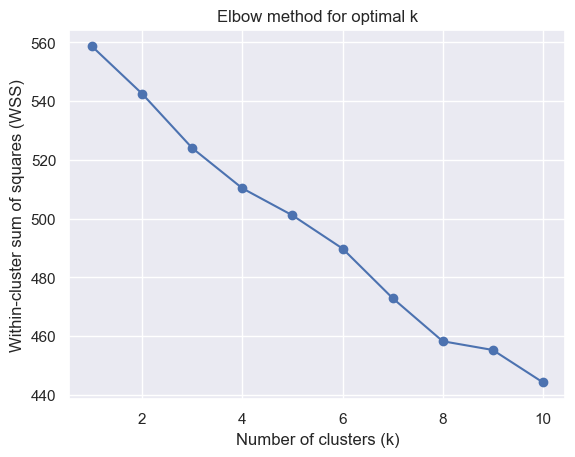

In [139]:
# define a range of values for k to try
k_values = range(1, 11)

# initialize an empty list to store the WSS for each k value
wss_values = []

# loop over the k values and compute the WSS for each
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=20, max_iter=1000, random_state=42)
    kmeans.fit(vectors)
    wss = kmeans.inertia_
    wss_values.append(wss)

# plot the WSS values as a function of k
plt.plot(k_values, wss_values, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WSS)')
plt.title('Elbow method for optimal k')
plt.show()


The WSS score plot is a diagnostic tool that is commonly used in k-means clustering to identify the optimal number of clusters for a given dataset. In general, the goal is to select a value of k that minimizes the WSS while still capturing the inherent structure in the data. In your plot, the "elbow point" occurs at around k=8, where the WSS starts to level off.

In [140]:
from sklearn.metrics import silhouette_score
k_values = range(2, 10)
# loop over the k values and compute the silhouette score for each
for k in k_values:
    kmeans = KMeans(n_clusters=k,init="k-means++", n_init=20, max_iter=1000, random_state=42)
    labels = kmeans.fit_predict(vectors)
    score = silhouette_score(vectors, labels)
    print(f"k={k}, silhouette score={score}")

k=2, silhouette score=0.43845657967615953
k=3, silhouette score=0.4531621794436798
k=4, silhouette score=0.46079453780080115
k=5, silhouette score=0.46759253622545227
k=6, silhouette score=0.4769853417487696
k=7, silhouette score=0.4865348559969295
k=8, silhouette score=0.49778203335377785
k=9, silhouette score=0.502565090881026


In general, a silhouette score of above 0.5 indicates a reasonable clustering solution, while a score above 0.7 indicates a strong separation between the clusters.  Based on the silhouette scores you provided, the optimal number of clusters is likely to be k=9, which has the highest silhouette score.

The k-means algorithm is used to group similar vectors together based on their similarities in terms of their TF-IDF (Term Frequency-Inverse Document Frequency) values. 

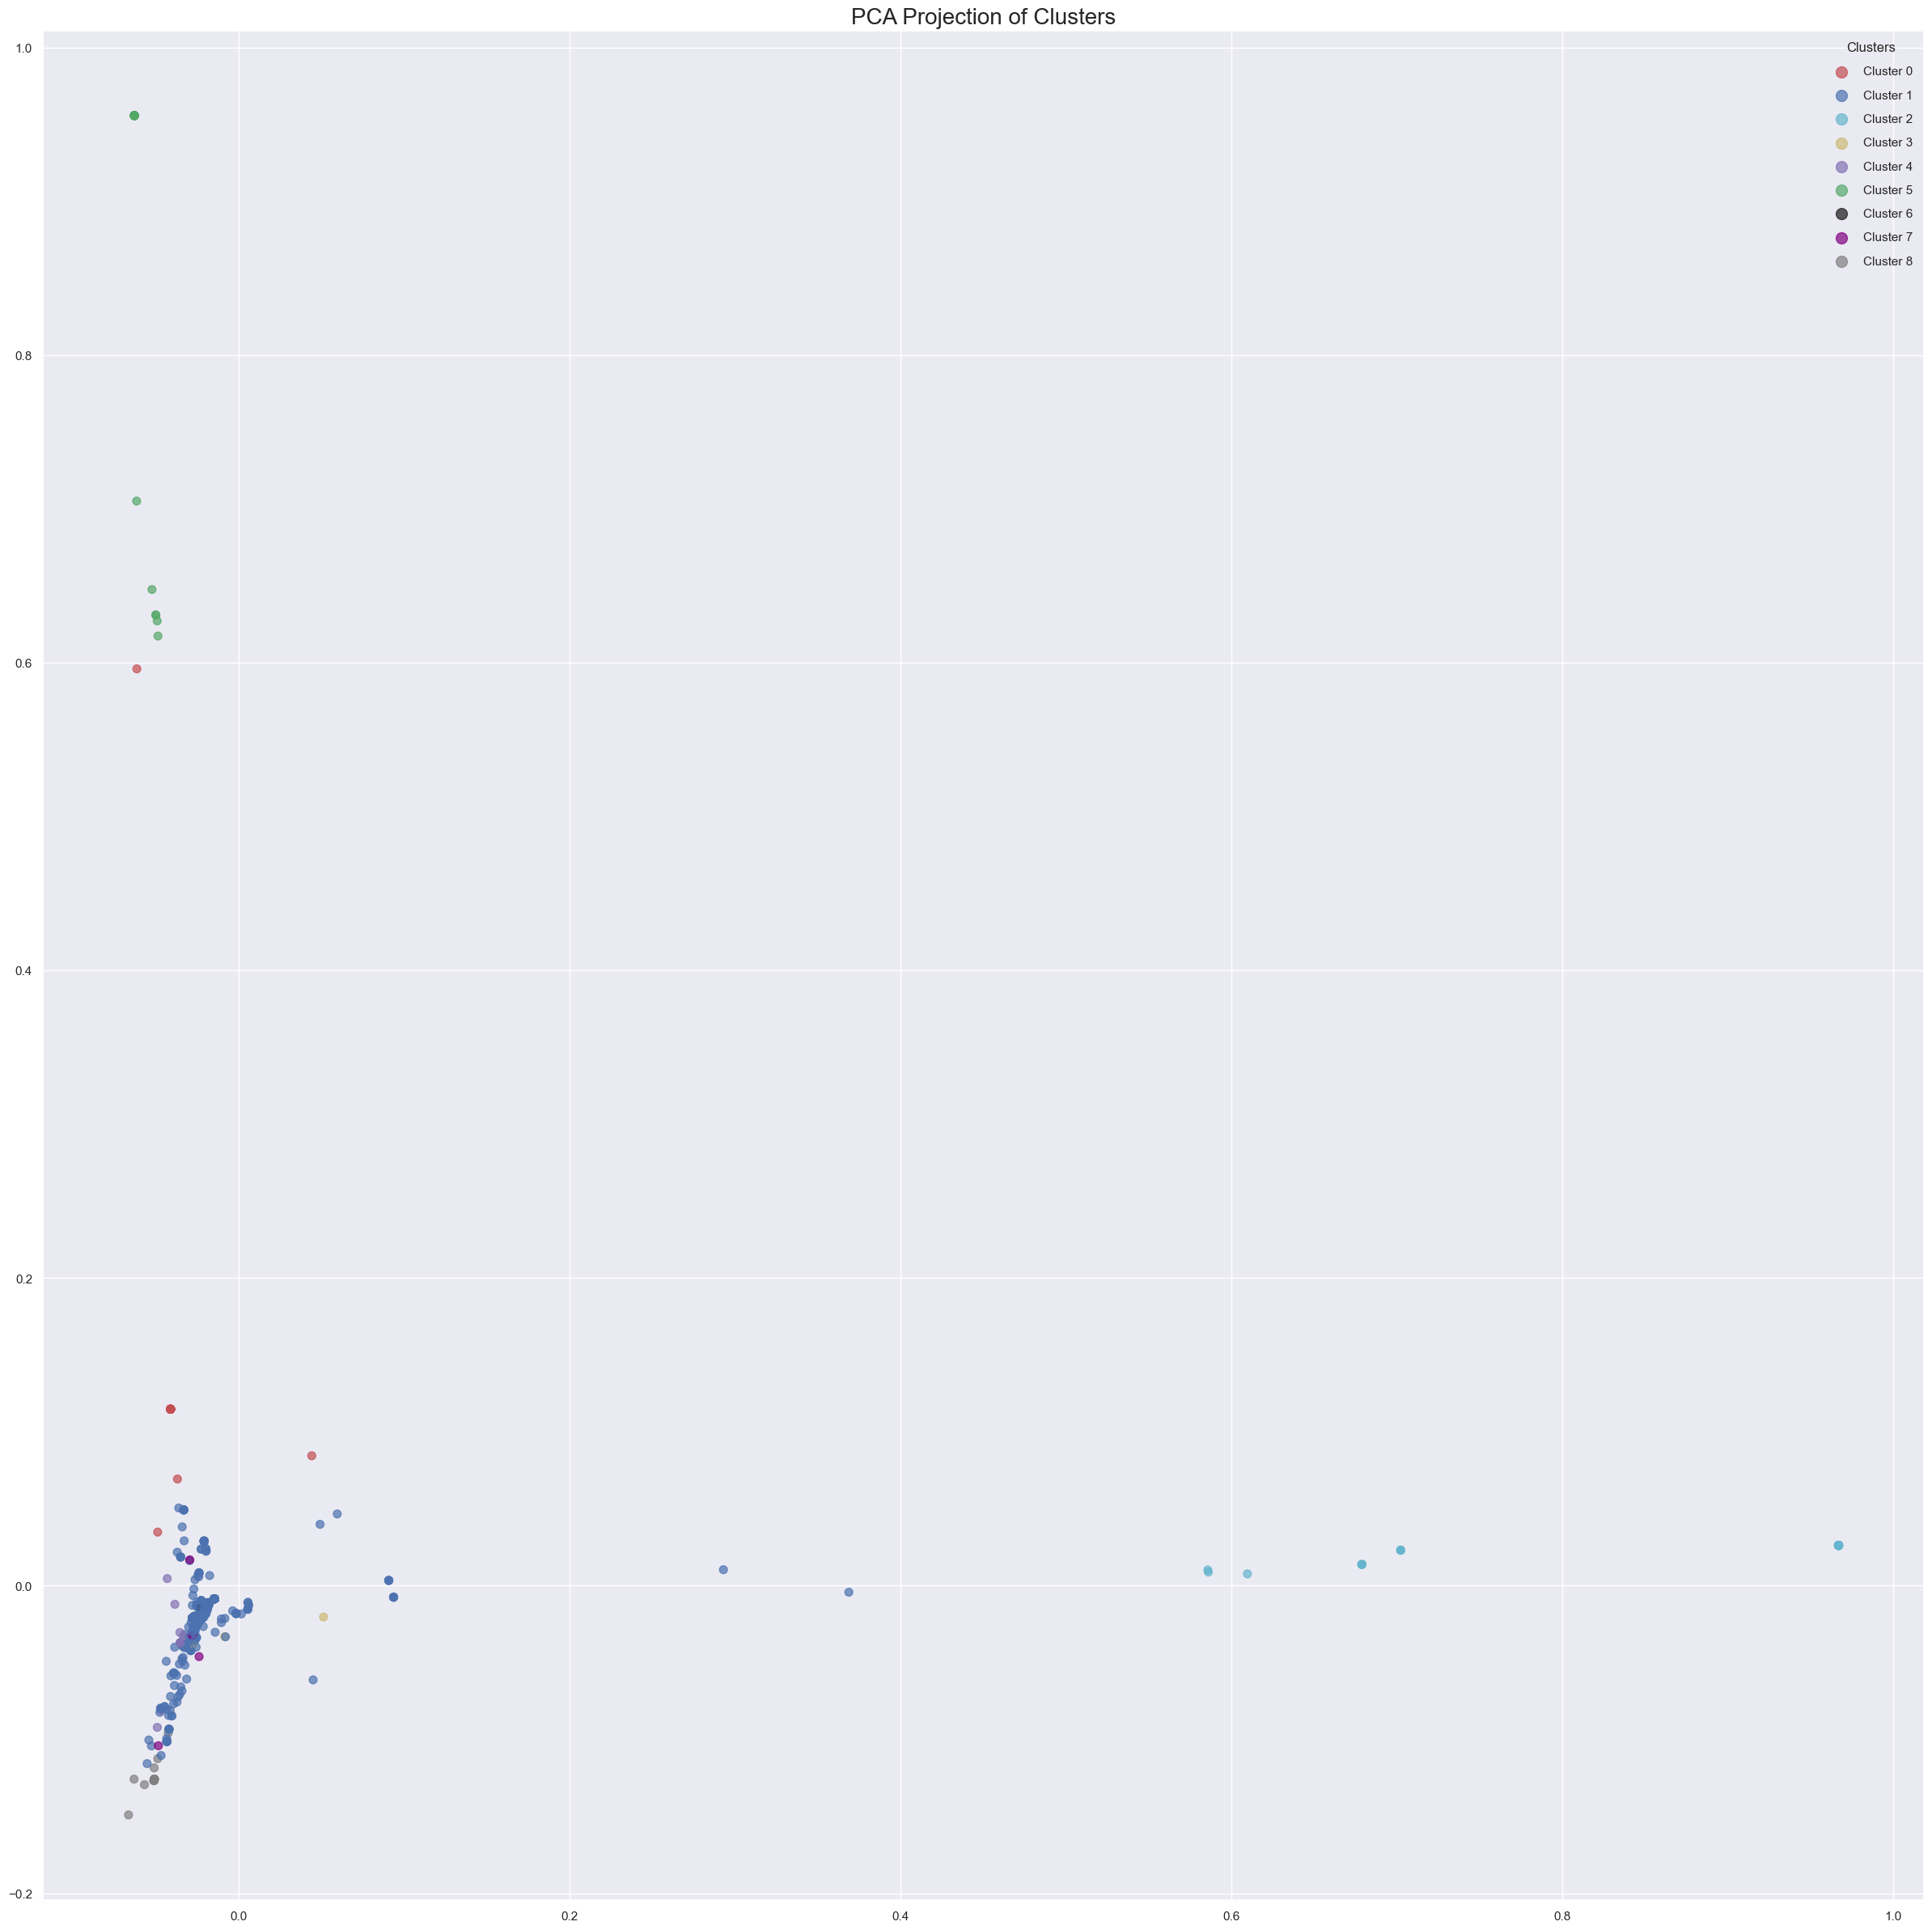

In [141]:
# visualize PCA transformed k-means clustering result
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# generate cluster indices for each vector
kmean_indices = model.fit_predict(vectors)
# reduce dimensionality to 2D
pca = PCA(n_components=2)
# stores the 2D coordinates of vectors
scatter_plot_points = pca.fit_transform(vectors.toarray())

colors = ["r", "b", "c", "y", "m", "g", "k", "purple", "grey"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(30,30))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices], alpha = 0.7, s=50)
plt.title("PCA Projection of Clusters", fontsize=20)

# add legend
for i in range(true_k):
    ax.scatter([], [], c=colors[i], alpha=0.7, s=100, label=f"Cluster {i}")
    ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title="Clusters", loc="upper right")

# annotate points
# for i, txt in enumerate(cleaned_docs):
#     ax.annotate(txt[0:5], (x_axis[i], y_axis[i]))

plt.savefig("data/kmeans_pca.png")

In [142]:
# generate cluster indices for each vector
kmean_indices = model.fit_predict(vectors)
# reduce dimensionality to 2D
pca = PCA(n_components=2)
# stores the 2D coordinates of vectors
scatter_plot_points = pca.fit_transform(vectors.toarray())

In [143]:
import plotly.graph_objs as go
import plotly.offline as pyo

# visualize k means clustering result
## color palette https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
colors = ["#ea5545", "#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6",]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

# create a list of hover text for each point
hover_text = ["Text: {}".format(txt) for txt in cleaned_docs]

# create a trace for each cluster
data = []
for i in range(true_k):
    trace = go.Scatter(
        x=[x_axis[j] for j in range(len(kmean_indices)) if kmean_indices[j] == i],
        y=[y_axis[j] for j in range(len(kmean_indices)) if kmean_indices[j] == i],
        mode='markers',
        marker=dict(
            color=colors[i],
            size=10,
            opacity=0.8,
            line=dict(width=0.5, color='white')
        ),
        text=[hover_text[j] for j in range(len(kmean_indices)) if kmean_indices[j] == i],
        name=f"Cluster {i}"
    )
    data.append(trace)

# create the layout
layout = go.Layout(
    title='PCA Visualization of Clusters',
    xaxis=dict(title='PC1'),
    yaxis=dict(title='PC2'),
    plot_bgcolor='white',
)

# plot the figure
fig = go.Figure(data=data, layout=layout)

# Change grid color and axis colors
fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', mirror=True, showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey', mirror=True, showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(zeroline=False)
fig.update_xaxes(zeroline=False)

pyo.iplot(fig)

Each point represents a vector in the input matrix, and the color of the point indicates which k-means cluster it belongs to. By inspecting the plot, you can get a sense of which vectors are most similar to each other, and which clusters are most distinct from each other.

You can also consider using t-SNE as an alternative method for visualizing the cluster structure in the data. t-SNE is a nonlinear dimensionality reduction technique that can often provide better separation between clusters compared to PCA. The TSNE class from the sklearn.manifold module can be used to perform t-SNE projection.


IndexError: list index out of range

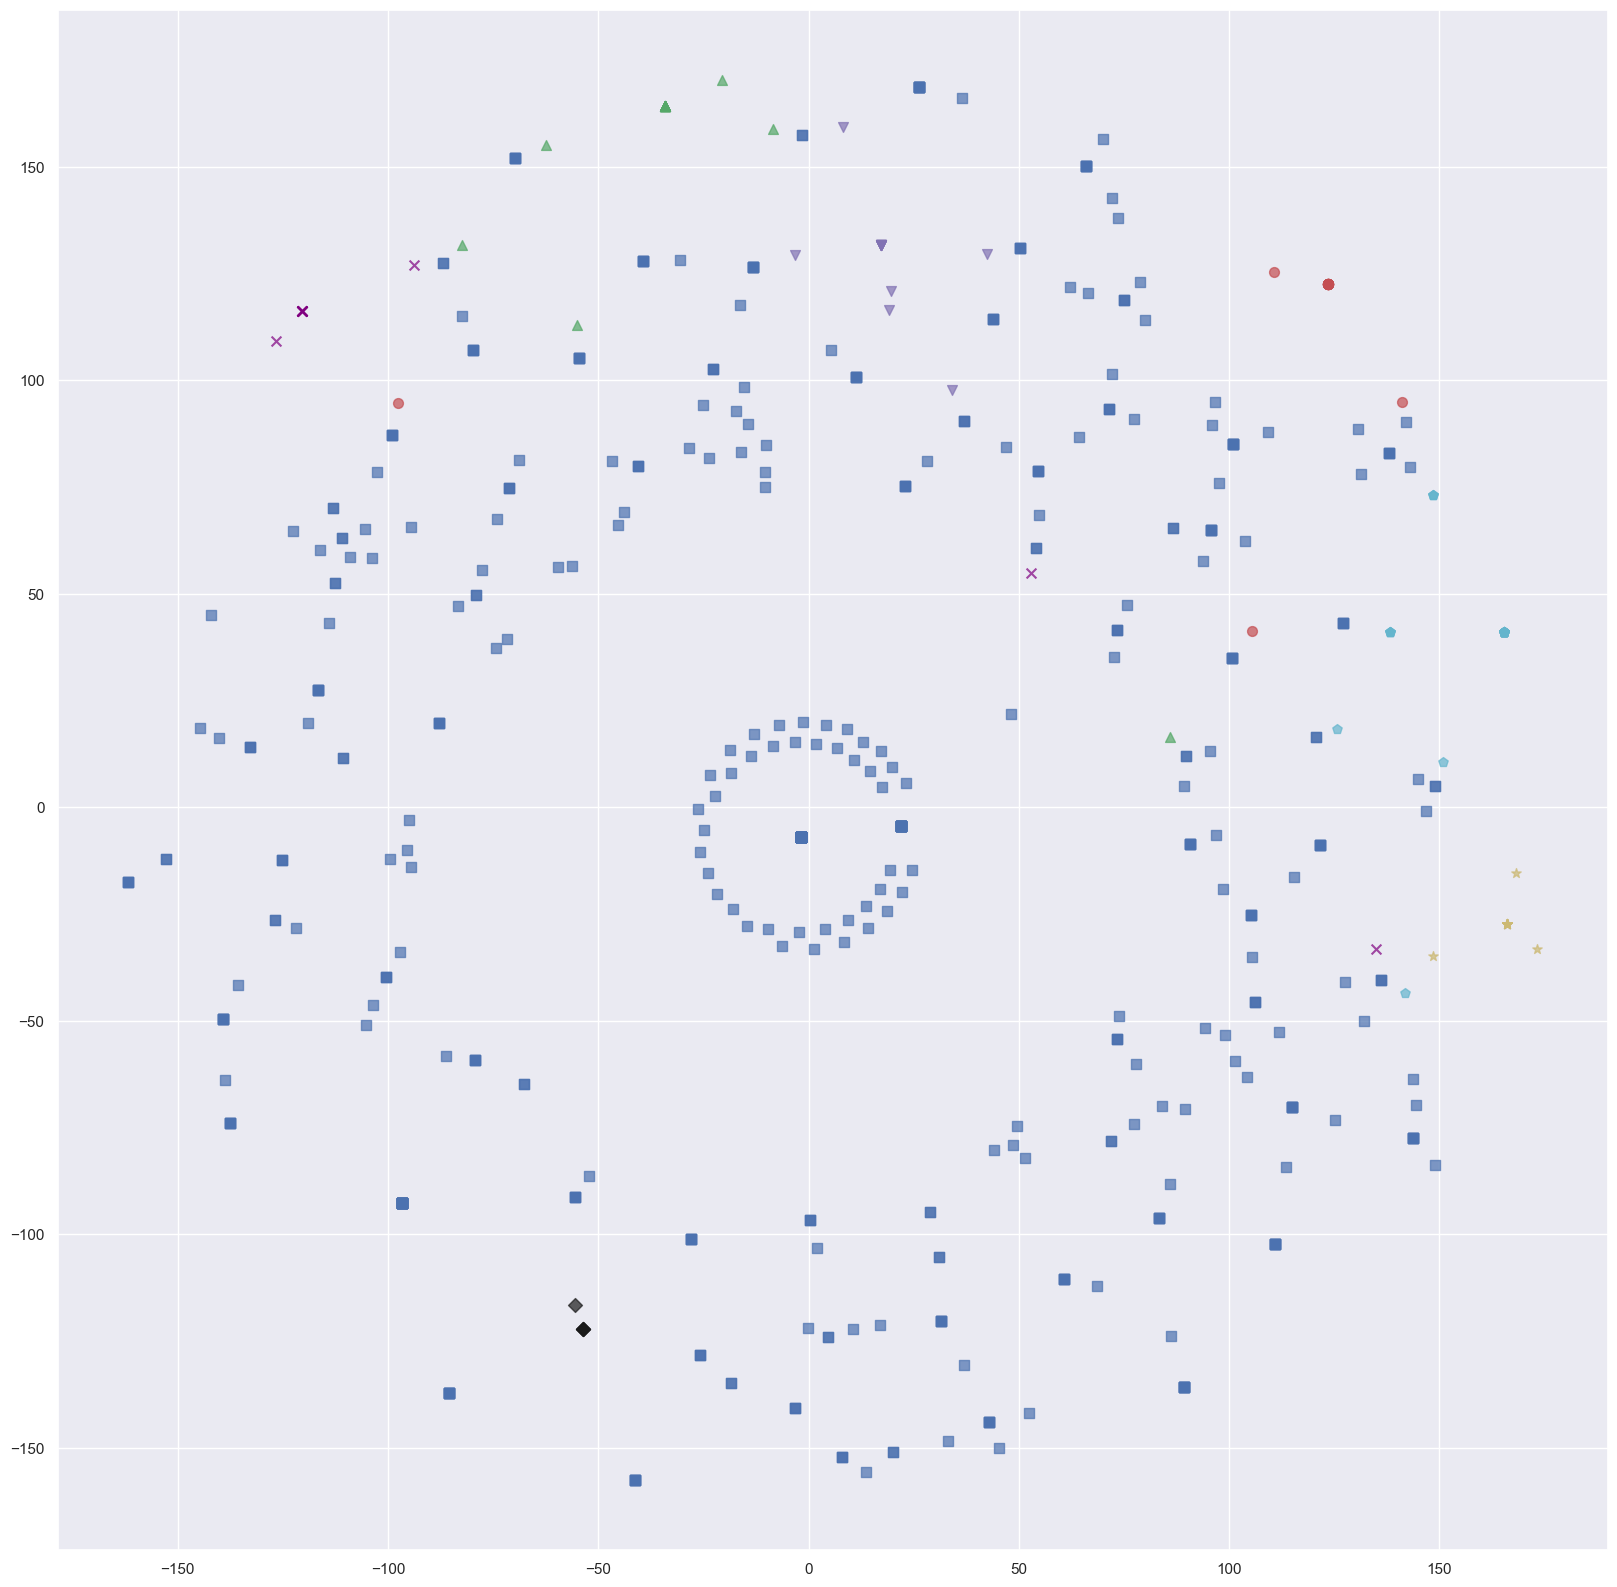

In [145]:
from sklearn.manifold import TSNE

# Generate cluster indices for each vector
kmean_indices = model.fit_predict(vectors)

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
scatter_plot_points = tsne.fit_transform(vectors.toarray())

# Define colors and markers for each cluster
colors = ["r", "b", "c", "y", "m", "g", "k", "purple"]
markers = ["o", "s", "p", "*", "v", "^", "D", "x"]

# Plot the t-SNE projection
fig, ax = plt.subplots(figsize=(20,20))

for i in range(true_k):
    mask = kmean_indices == i
    ax.scatter(scatter_plot_points[mask, 0], scatter_plot_points[mask, 1], c=colors[i], marker=markers[i], alpha=0.7, s=50, label=f"Cluster {i}")

ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title="Clusters", loc="upper right")
plt.title("t-SNE Visualization of Clusters")
plt.show()
plt.savefig("data/kmeans_tsne.png")

can't find a clear clustering pattern in the t-SNE projection, it's possible that the underlying data may not have a well-defined structure or separation that can be easily captured by t-SNE. This can happen if the data is noisy, contains outliers, or has a high degree of overlap between the clusters.

### Topic Modeling (LDA)

LDA, on the other hand, is a supervised classification algorithm that aims to find a linear combination of features that maximally separates the classes in the data. The algorithm computes the between-class and within-class scatter matrices of the data, and then finds the eigenvectors of the ratio of these matrices that correspond to the largest eigenvalues. The resulting eigenvectors define a subspace that maximally separates the classes, and can be used to project the data onto a lower-dimensional space for classification. LDA is a powerful algorithm that can work well with small to medium-sized datasets, but it has some limitations such as the assumption of Gaussian distributions, the sensitivity to outliers, and the difficulty in handling nonlinear or complex boundaries.

K-means is an unsupervised clustering algorithm that aims to partition the data into K clusters based on the similarity between the data points, while LDA is a supervised classification algorithm that aims to find a linear combination of features that maximally separates the classes in the data.

In [113]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [146]:
stopwords = stopwords.words("english")

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        try:
            text = text.lower()
            #print(text)
            # Skip processing if the text is empty or None
            if not text:
                texts_out.append("")
                continue

            doc = nlp(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_postags:
                    new_text.append(token.lemma_)
            final = " ".join(new_text)
            texts_out.append(final)
        except Exception as e:
            #print(e)
            texts_out.append("")
    return (texts_out)

lemmatized_texts = lemmatization(descriptions)
print(lemmatized_texts)

['s', 'live puteoli camp emperor command valerius', 'dead', 'ide guide religious guide teach name otherwise know', 'day none day ide die', '', '', 'echio', 's never', 'woman avenge', 'cilix slave fuscus cilix', 'moisture', 'p(ublius', 'caetronius', 'more public arriû spaerus', 'eunuch court', 'doctor slave emperor titus poope well here', 'mistress primigenia come puteoli tyanian street ask messius money lender slave phoebus', 'love amplianda ianuarius love veneria ask mistress venu keep mind also now ask', '', 'send second time female lamb', 'name', 'name', 'ask affair safe', '', 'vibidius', 'rejoice carry', 'return return entangle entangle', 'here pronounce ostius', 'mish mash', 'here love wise', '', '', '', 'm(arcus l(---', '', 'quintus', 'love', 'cake loaf bread mme', 'bucolus', 'good luck', 'suck', 'phoebus fall ill', 'unknown meaning', 'silentiolus', 'third day ide spend denarius ass tunic', 'friend here servant name epaphroditus terrible whole time finally kick then spend sestert

In [147]:
# remove stopwords
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print(data_words[0:2])

[[], ['live', 'puteoli', 'camp', 'emperor', 'command', 'valerius']]


In [148]:
# bigrams and trigrams
bigrams_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=50)
trigrams_phrases = gensim.models.Phrases(bigrams_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigrams_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams)
print (data_bigrams_trigrams)

[[], ['live', 'puteoli', 'camp', 'emperor', 'command', 'valerius'], ['dead'], ['ide', 'guide', 'religious', 'guide', 'teach', 'name', 'otherwise', 'know'], ['day', 'none', 'day', 'ide', 'die'], [], [], ['echio'], ['never'], ['woman', 'avenge'], ['cilix', 'slave', 'fuscus', 'cilix'], ['moisture'], ['ublius'], ['caetronius'], ['more', 'public', 'arriu', 'spaerus'], ['eunuch', 'court'], ['doctor', 'slave', 'emperor', 'titus', 'poope', 'well', 'here'], ['mistress', 'primigenia', 'come', 'puteoli', 'tyanian', 'street', 'ask', 'messius', 'money', 'lender', 'slave', 'phoebus'], ['love', 'amplianda', 'ianuarius', 'love', 'veneria', 'ask', 'mistress', 'venu', 'keep', 'mind', 'also', 'now', 'ask'], [], ['send', 'second', 'time', 'female', 'lamb'], ['name'], ['name'], ['ask', 'affair', 'safe'], [], ['vibidius'], ['rejoice', 'carry'], ['return', 'return', 'entangle', 'entangle'], ['here', 'pronounce', 'ostius'], ['mish', 'mash'], ['here', 'love', 'wise'], [], [], [], ['arcus'], [], ['quintus'], ['

In [149]:
# tf-idf removal
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
corpus = [id2word.doc2bow(data_bigrams_trigrams) for data_bigrams_trigrams in data_bigrams_trigrams]
print(corpus)

tfidf = TfidfModel(corpus, id2word = id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf.idfs]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[[], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1)], [(7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1)], [], [], [(18, 1)], [(19, 1)], [(20, 1), (21, 1)], [(22, 2), (23, 1), (24, 1)], [(25, 1)], [(26, 1)], [(27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1)], [(2, 1), (24, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(4, 1), (24, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(39, 2), (43, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1)], [], [(58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(10, 1)], [(10, 1)], [(39, 1), (63, 1), (64, 1)], [], [(65, 1)], [(66, 1), (67, 1)], [(68, 2), (69, 2)], [(35, 1), (70, 1), (71, 1)], [(72, 1), (73, 1)], [(35, 1), (53, 1), (74, 1)], [], [], [], [(75, 1)], [], [(76, 1)], [(53, 1)], [(77, 1), (78, 1), (79, 1), (80, 1)], [(81, 1)], [(82, 1), (83, 1)], [(84, 1)], [(45, 1), (85, 1), (86, 1)]

In [150]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[]
camp


In [151]:
# save corpus and id2word
pickle.dump(corpus, open("app/data/corpus.pkl", "wb"))
id2word.save("app/data/id2word.gensim")

In [152]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

Improve the model performance:
- hyperparameter tuning
    - number of topics, the number of iterations, the alpha and beta parameters, etc
    - use grid search or randomized search to find the best hyperparameters

Visualization:
- word clouds, topic hierarchies, or network visualizations

In [153]:
# save the model
lda_model.save("app/data/text_model.model")

In [154]:
# load model
#new_model = gensim.models.ldamodel.LdaModel.load("models/text_model.model")

In [155]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [156]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.067203  0.229731       1        1  14.436556
2      0.227940  0.080219       2        1  14.056906
3     -0.230329  0.119741       3        1  10.980264
0      0.064737 -0.255810       4        1  10.890583
7      0.101724  0.200409       5        1  10.498473
5     -0.156267 -0.199491       6        1  10.438160
4     -0.173986 -0.039344       7        1   9.990998
1      0.033500 -0.032715       8        1   9.767947
6      0.199884 -0.102740       9        1   8.940111, topic_info=            Term       Freq      Total Category  logprob  loglift
34          here  46.000000  46.000000  Default  30.0000  30.0000
81          good  38.000000  38.000000  Default  29.0000  29.0000
52          love  36.000000  36.000000  Default  28.0000  28.0000
14           day  30.000000  30.000000  Default  27.0000  27.0000
10          name  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
424        dance   1.853586   2.562198   Topic9  -4.9852   2.0909
1051         few   1.785990   2.495790   Topic9  -5.0224   2.0800
1444  ungrateful   1.706875   2.415488   Topic9  -5.0677   2.0674
1398      charia   1.699652   2.413599   Topic9  -5.0719   2.0639
1399    dedicate   1.699652   2.413599   Topic9  -5.0719   2.0639

[306 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
461       9  0.704726        add
1311      4  0.807456        adi
1368      5  0.873803  adulterer
947       8  0.808739        air
848       3  0.866350    albanus
...     ...       ...        ...
414       7  0.922196      write
420       7  0.736459     writer
690       2  0.921558       year
904       5  0.786201        yet
1092      7  0.773036      young

[277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 4, 1, 8, 6, 5, 2, 7])

Word cloud:

A word cloud is a graphical representation of word frequency within a text. The most frequent words are shown in larger font sizes and positioned more prominently in the image. The visualization is a way to quickly and easily convey the most relevant words in a text or corpus. In the context of LDA modeling, the word cloud can be used to visualize the most relevant words associated with each topic.

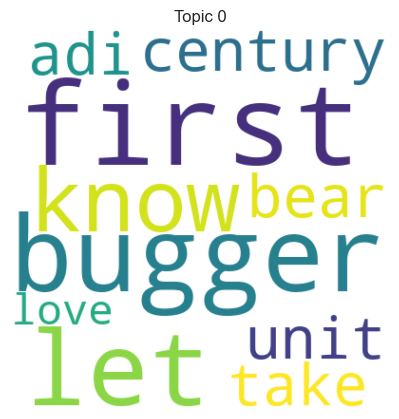

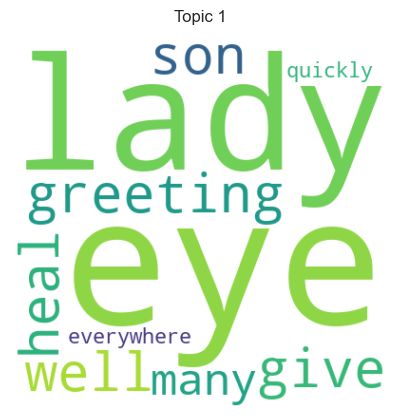

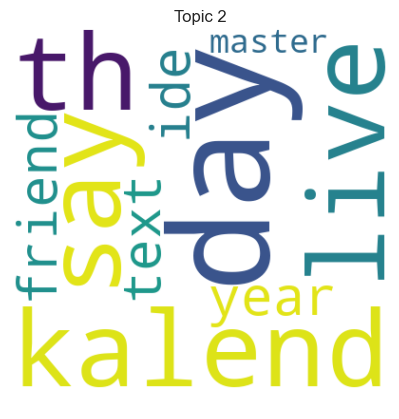

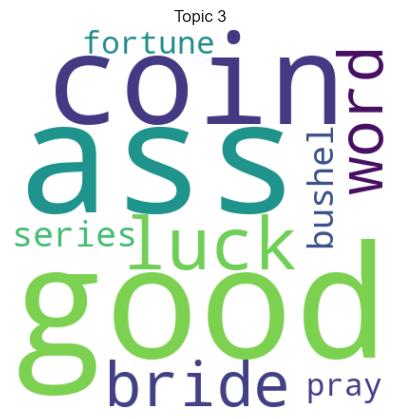

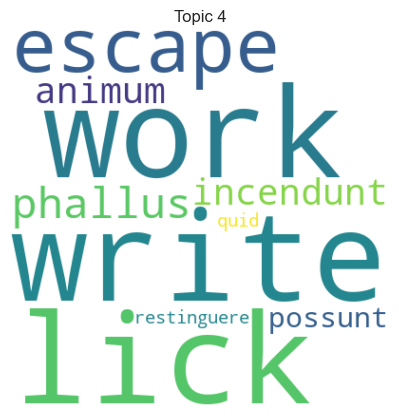

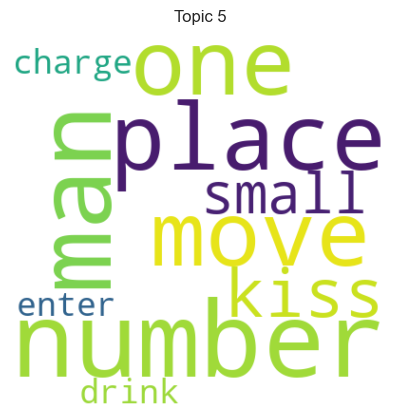

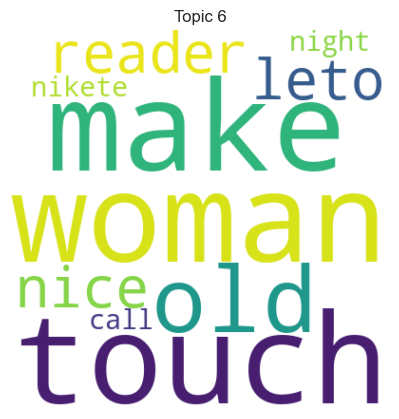

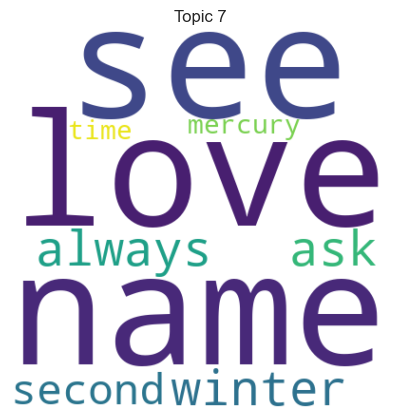

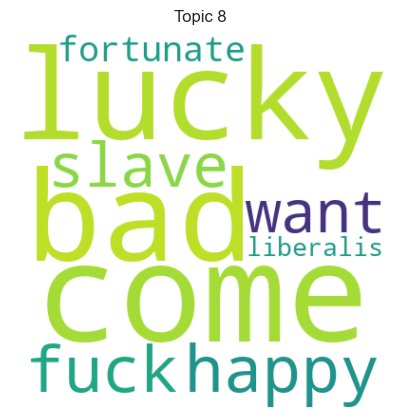

In [157]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# extract the top words from each topic
top_words = []
for i in range(9):
    top_words.append([word[0] for word in lda_model.show_topic(i, topn=10)])

# generate a word cloud for each topic
for i in range(9):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(' '.join(top_words[i]))
    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Topic " + str(i))
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

### Geospatial Visualization

- cluster data: sentence tokenizer -> encoder->umap/tsne-> 2d data
    - bigram similarity and frequency (tsne)
    - each sentence is visualized as a point
    - connecting the points to construct an inner topological structure
    - edge building: calculate connectivity, use python library Datashader to optimize a less busy view 
- GIS?


- https://www.kaggle.com/code/ericlayer/airline-satisfaction-clustering-w-umap-dbscan/notebook
- https://inside-machinelearning.com/en/efficient-sentences-embedding-visualization-tsne/
- https://arize.com/blog/nlp-sentiment-classification-monitoring/
- https://www.johnkraszewski.com/nlp
- https://towardsdatascience.com/text-classification-with-bert-2e0297ea188a#b2b6


References:
- The Classical Language Toolkit: An NLP Framework for Pre-Modern Languages, https://aclanthology.org/2021.acl-demo.3/
- non english NER: https://www.youtube.com/watch?v=zywMBYmV6Ew&list=PL2VXyKi-KpYuKYUkf1aODP4vHpOh7yvjr&index=12